In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
import cdsapi
import os 

In [2]:
DOWNLOAD = False

In [3]:
if DOWNLOAD:

    path="../data/temp/" #temporary path
    final_path = "../data/era5/" #save path

    years_to_download = [  ['1980', '1981', '1982', '1983', '1984',], ['1985', '1986', '1987','1988', '1989'],
                        ['1990','1991', '1992', '1993', '1994',], ['1995', '1996', '1997', '1998','1999'],
                        ['2000', '2001','2002', '2003', '2004',], ['2005', '2006', '2007', '2008', '2009'],
                        ['2010','2011', '2012','2013', '2014'], ['2015', '2016', '2017', '2018', '2019'],
                        ['2020', '2021', '2022', '2023','2024']]

    client = cdsapi.Client(
        url="https://cds.climate.copernicus.eu/api",
        key="b0474ce3-c4ed-4747-b666-66dcca14d8ea"
    )
    area = [5.3, -73.9, -33.9, -34.9] 
    for years in years_to_download:

        filename = client.retrieve(
            "reanalysis-era5-single-levels",
            {
                "product_type": "reanalysis",
                "variable":[ "2m_temperature",
                                    "total_precipitation"
                                ],
                "year": years_to_download,
                "month": ["01", "02", "03","04", "05", "06",
                            "07", "08", "09","10", "11", "12"],
                "day":  [ "01", "02", "03","04", "05", "06",
                            "07", "08", "09","10", "11", "12",
                            "13", "14", "15","16", "17", "18",
                            "19", "20", "21","22", "23", "24",
                            "25", "26", "27","28", "29", "30","31"],
                "time": ["00:00", "06:00", "12:00", "18:00"],
                "data_format": "netcdf",
                "download_format": "zip",
                "area": area,
                }
        ).download()

    os.system(f"unzip {filename} -d {path}")
    os.system(f"rm {filename}")
    new_files = [i for i in os.listdir(path) if i.endswith(".nc")]
    for file in new_files:     #rename files 
        new_name = f"{min(years_to_download)}-{max(years_to_download)}-{file.split('-')[-1]}"
        os.rename(os.path.join(path, file), os.path.join(path, new_name))
        os.system(f"mv {os.path.join(path, new_name)} {os.path.join(final_path, new_name)}")

In [26]:
var_type = {
    "accum":"total_precipitation",
    "instant":"2m_temperature"
}

prep = xr.open_mfdataset('../data/era5/*-accum.nc', concat_dim="valid_time",combine='nested')
temp = xr.open_mfdataset('../data/era5/*-instant.nc', concat_dim="valid_time",combine='nested')
merged = xr.merge([prep, temp],compat='no_conflicts')

In [30]:
print(prep.tp.shape)
print(temp.t2m.shape)
print(merged.tp.shape, merged.t2m.shape)
del prep, temp

(65748, 157, 157)
(65748, 157, 157)
(65748, 157, 157) (65748, 157, 157)


Text(0.5, 1.0, 'Total Precipitation over Selected Region')

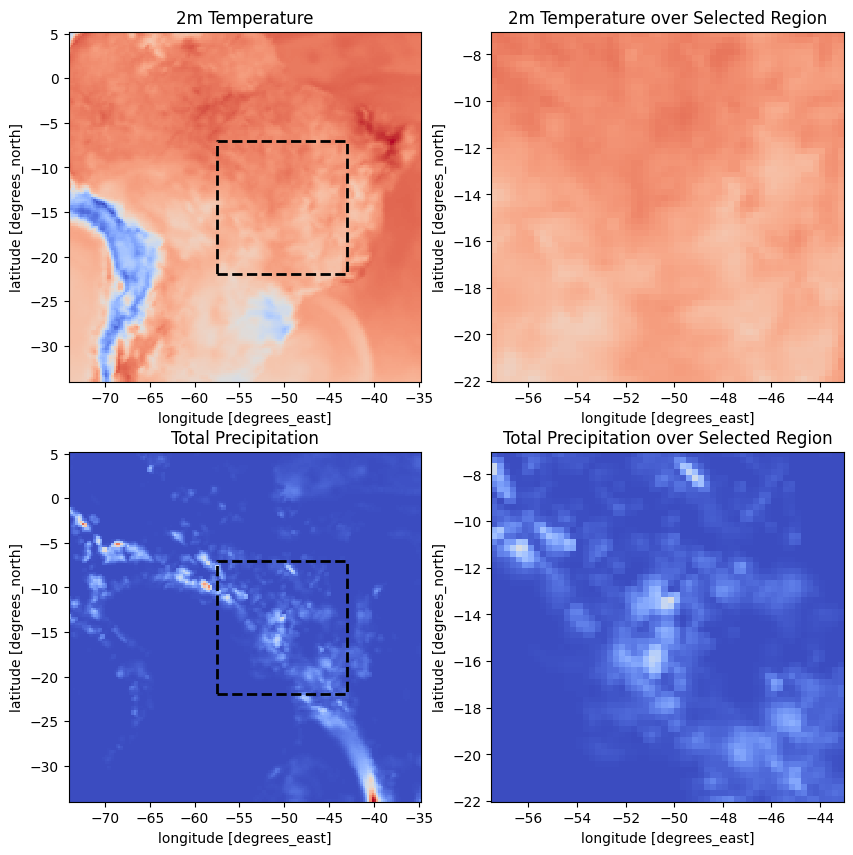

In [67]:
lat_min, lat_max = -22.0, -7.0
lon_min, lon_max = -57.5, -43.0
cropped = merged.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

tmin= merged.t2m.isel(valid_time=0).min().values.item()
tmax= merged.t2m.isel(valid_time=0).max().values.item()

merged.t2m.isel(valid_time=0).plot(ax=axs[0,0], cmap='coolwarm', add_colorbar=False)
cropped.t2m.isel(valid_time=0).plot(ax=axs[0,1], cmap='coolwarm', add_colorbar=False, vmin=tmin, vmax=tmax)

axs[0,0].plot([lon_min, lon_max, lon_max, lon_min, lon_min],
        [lat_min, lat_min, lat_max, lat_max, lat_min],
        color='black', linewidth=2, linestyle='--', label='Selected Region')


tmin= merged.tp.isel(valid_time=0).min().values.item()
tmax= merged.tp.isel(valid_time=0).max().values.item()

merged.tp.isel(valid_time=0).plot(ax=axs[1,0], cmap='coolwarm', add_colorbar=False)
cropped.tp.isel(valid_time=0).plot(ax=axs[1,1], cmap='coolwarm', add_colorbar=False, vmin=tmin, vmax=tmax)

axs[1,0].plot([lon_min, lon_max, lon_max, lon_min, lon_min],
        [lat_min, lat_min, lat_max, lat_max, lat_min],
        color='black', linewidth=2, linestyle='--', label='Selected Region')

axs[0,0].set_title("2m Temperature")
axs[0,1].set_title("2m Temperature over Selected Region")
axs[1,0].set_title("Total Precipitation")
axs[1,1].set_title("Total Precipitation over Selected Region")